# Maleria Cell Classification using Tensorflow

# Mount Drive

In [ ]:
# mount Drive with Colab
from google.colab import drive
drive.mount('/content/mydrive/')

# Import Libraries

In [ ]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, Flatten
from keras.applications.vgg19 import VGG19
from keras import metrics
from keras import Model, layers

# Load Dataset

In [ ]:
# path of images folder
cell_images_path='/content/mydrive/MyDrive/dataset/Malaria_Detection-dataset/cell_images/'
# folder name
os.listdir(cell_images_path)

In [ ]:
# Parasitized images
Parasitized_images='/content/mydrive/MyDrive/dataset/Malaria_Detection-dataset/cell_images/Parasitized/'
os.listdir(Parasitized_images)

In [ ]:
# Uninfected images
Uninfected_images='/content/mydrive/MyDrive/dataset/Malaria_Detection-dataset/cell_images/Uninfected/'
os.listdir(Uninfected_images)

In [ ]:
# count the number of images in Uninfected and Parasitized images
print('total un infected images =' , len(os.listdir(Uninfected_images)))
print('total Parasitized images =' , len(os.listdir(Parasitized_images)))

# EDA

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

### Splitting the training and testing dataset

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(cell_images_path,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size)
val_dataset = tf.keras.utils.image_dataset_from_directory(cell_images_path,validation_split=0.2,subset="validation",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

### Class name of training and validation

In [ ]:
train_class_labels = train_dataset.class_names
print('Name of Training class name :',train_class_labels)
val_class_labels = val_dataset.class_names
print('Name of Validation class name :',val_class_labels)

# Visulization

### Training Dataset images

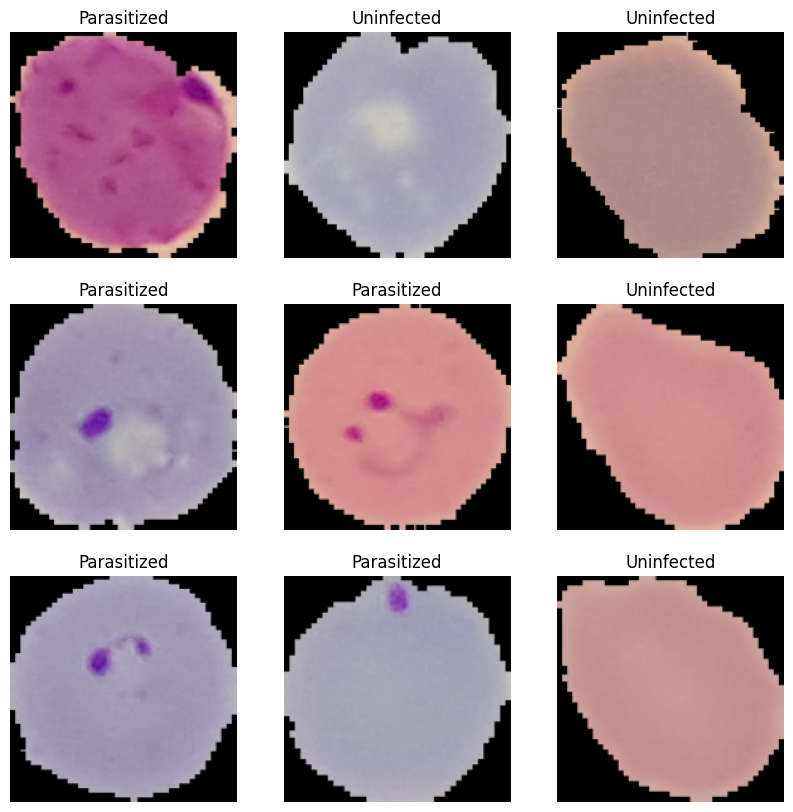

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class_labels[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Validation Dataset

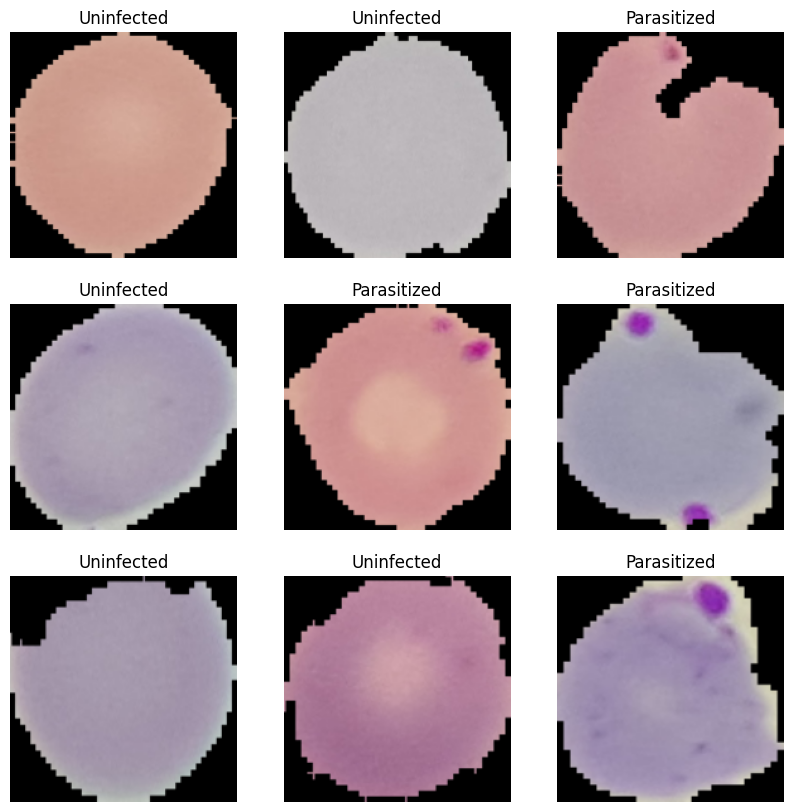

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(val_class_labels[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in val_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# VGG19 model Building

In [10]:
# instantiating the VGG19 model
vgg19 = VGG19(input_shape=[img_width, img_height] + [3],weights='imagenet',include_top=False)

# do not train the existing weights
for layer in vgg19.layers:
  layer.trainable = False

# defining input and output to the model
x = Flatten()(vgg19.output)
prediction = Dense(1, activation='sigmoid')(x)

80134624/80134624 [==============================] - 1s 0us/step


In [11]:
# create a model object
vgg19_model = Model(inputs = vgg19.input, outputs = prediction)

# view the structure of the model
vgg19_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [12]:
# tell the model what cost and optimization method to use

metrics = ['accuracy',
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall')
          ]

vgg19_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=metrics
)

# VGG19 model Training

In [13]:
# count the number of images in Uninfected and Parasitized images
Uninfected_images=len(os.listdir(Uninfected_images))
Parasitized_images=len(os.listdir(Parasitized_images))

In [14]:
# Getting the sum of both the training images and validation images
total_train = Parasitized_images + Uninfected_images
total_val = Parasitized_images + Uninfected_images

In [ ]:
history = vgg19_model.fit(train_dataset, steps_per_epoch = total_train // batch_size,
                       epochs = 10,
                       validation_data = val_dataset,
                       validation_steps = total_val // batch_size)

Epoch 1/10
 13/861 [..............................] - ETA: 7:43:46 - loss: 2.6353 - accuracy: 0.6707 - precision: 0.6684 - recall: 0.6386

# VGG19 model Testing

In [ ]:
model_test_performace = vgg19_model.evaluate(val_dataset)
print(model_test_performace)

# CNN Model Building

In [10]:
num_classes = len(train_class_labels)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Model Training

In [ ]:
epochs=10
history_cnn = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/10
689/689 [==============================] - 2207s 3s/step - loss: 0.3204 - accuracy: 0.8690 - val_loss: 0.1947 - val_accuracy: 0.9320
Epoch 2/10
689/689 [==============================] - 858s 1s/step - loss: 0.1704 - accuracy: 0.9415 - val_loss: 0.1788 - val_accuracy: 0.9418
Epoch 3/10
217/689 [========>.....................] - ETA: 8:56 - loss: 0.1462 - accuracy: 0.9541

# CNN Model Testing

In [ ]:
model_test_performace_cnn = model.evaluate(val_dataset)
print(model_test_performace_cnn)

In [ ]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Maleria Cell Detection using YOLOV8 Model

## Setup

In [ ]:
!nvidia-smi

Tue Aug  1 07:13:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   8967MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.0/78.2 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

# Load Label Malaria Detection Dataset From Roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="BnOKO33k1FISWz1WknAs")
project = rf.workspace("new-workspace-7yg6q").project("malariadetection_new")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.20, to fix: `pip install ultralytics==8.0.134`


Extracting Dataset Version Zip to Malaria-Classification-2 in yolov8:: 100%|██████████| 180/180 [00:00<00:00, 2211.47it/s]


# Train Dataset

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

Ultralytics YOLOv8.0.20 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/Malaria-Classification-2/data.yaml, epochs=25, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, si

In [ ]:
!ls /content/datasets/runs/detect/train/

args.yaml					    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1690662649.6c9038dd8ccb.2147.0  train_batch2.jpg
F1_curve.png					    train_batch60.jpg
P_curve.png					    train_batch61.jpg
PR_curve.png					    train_batch62.jpg
R_curve.png					    val_batch0_labels.jpg
results.csv					    val_batch0_pred.jpg
results.png					    weights


/content


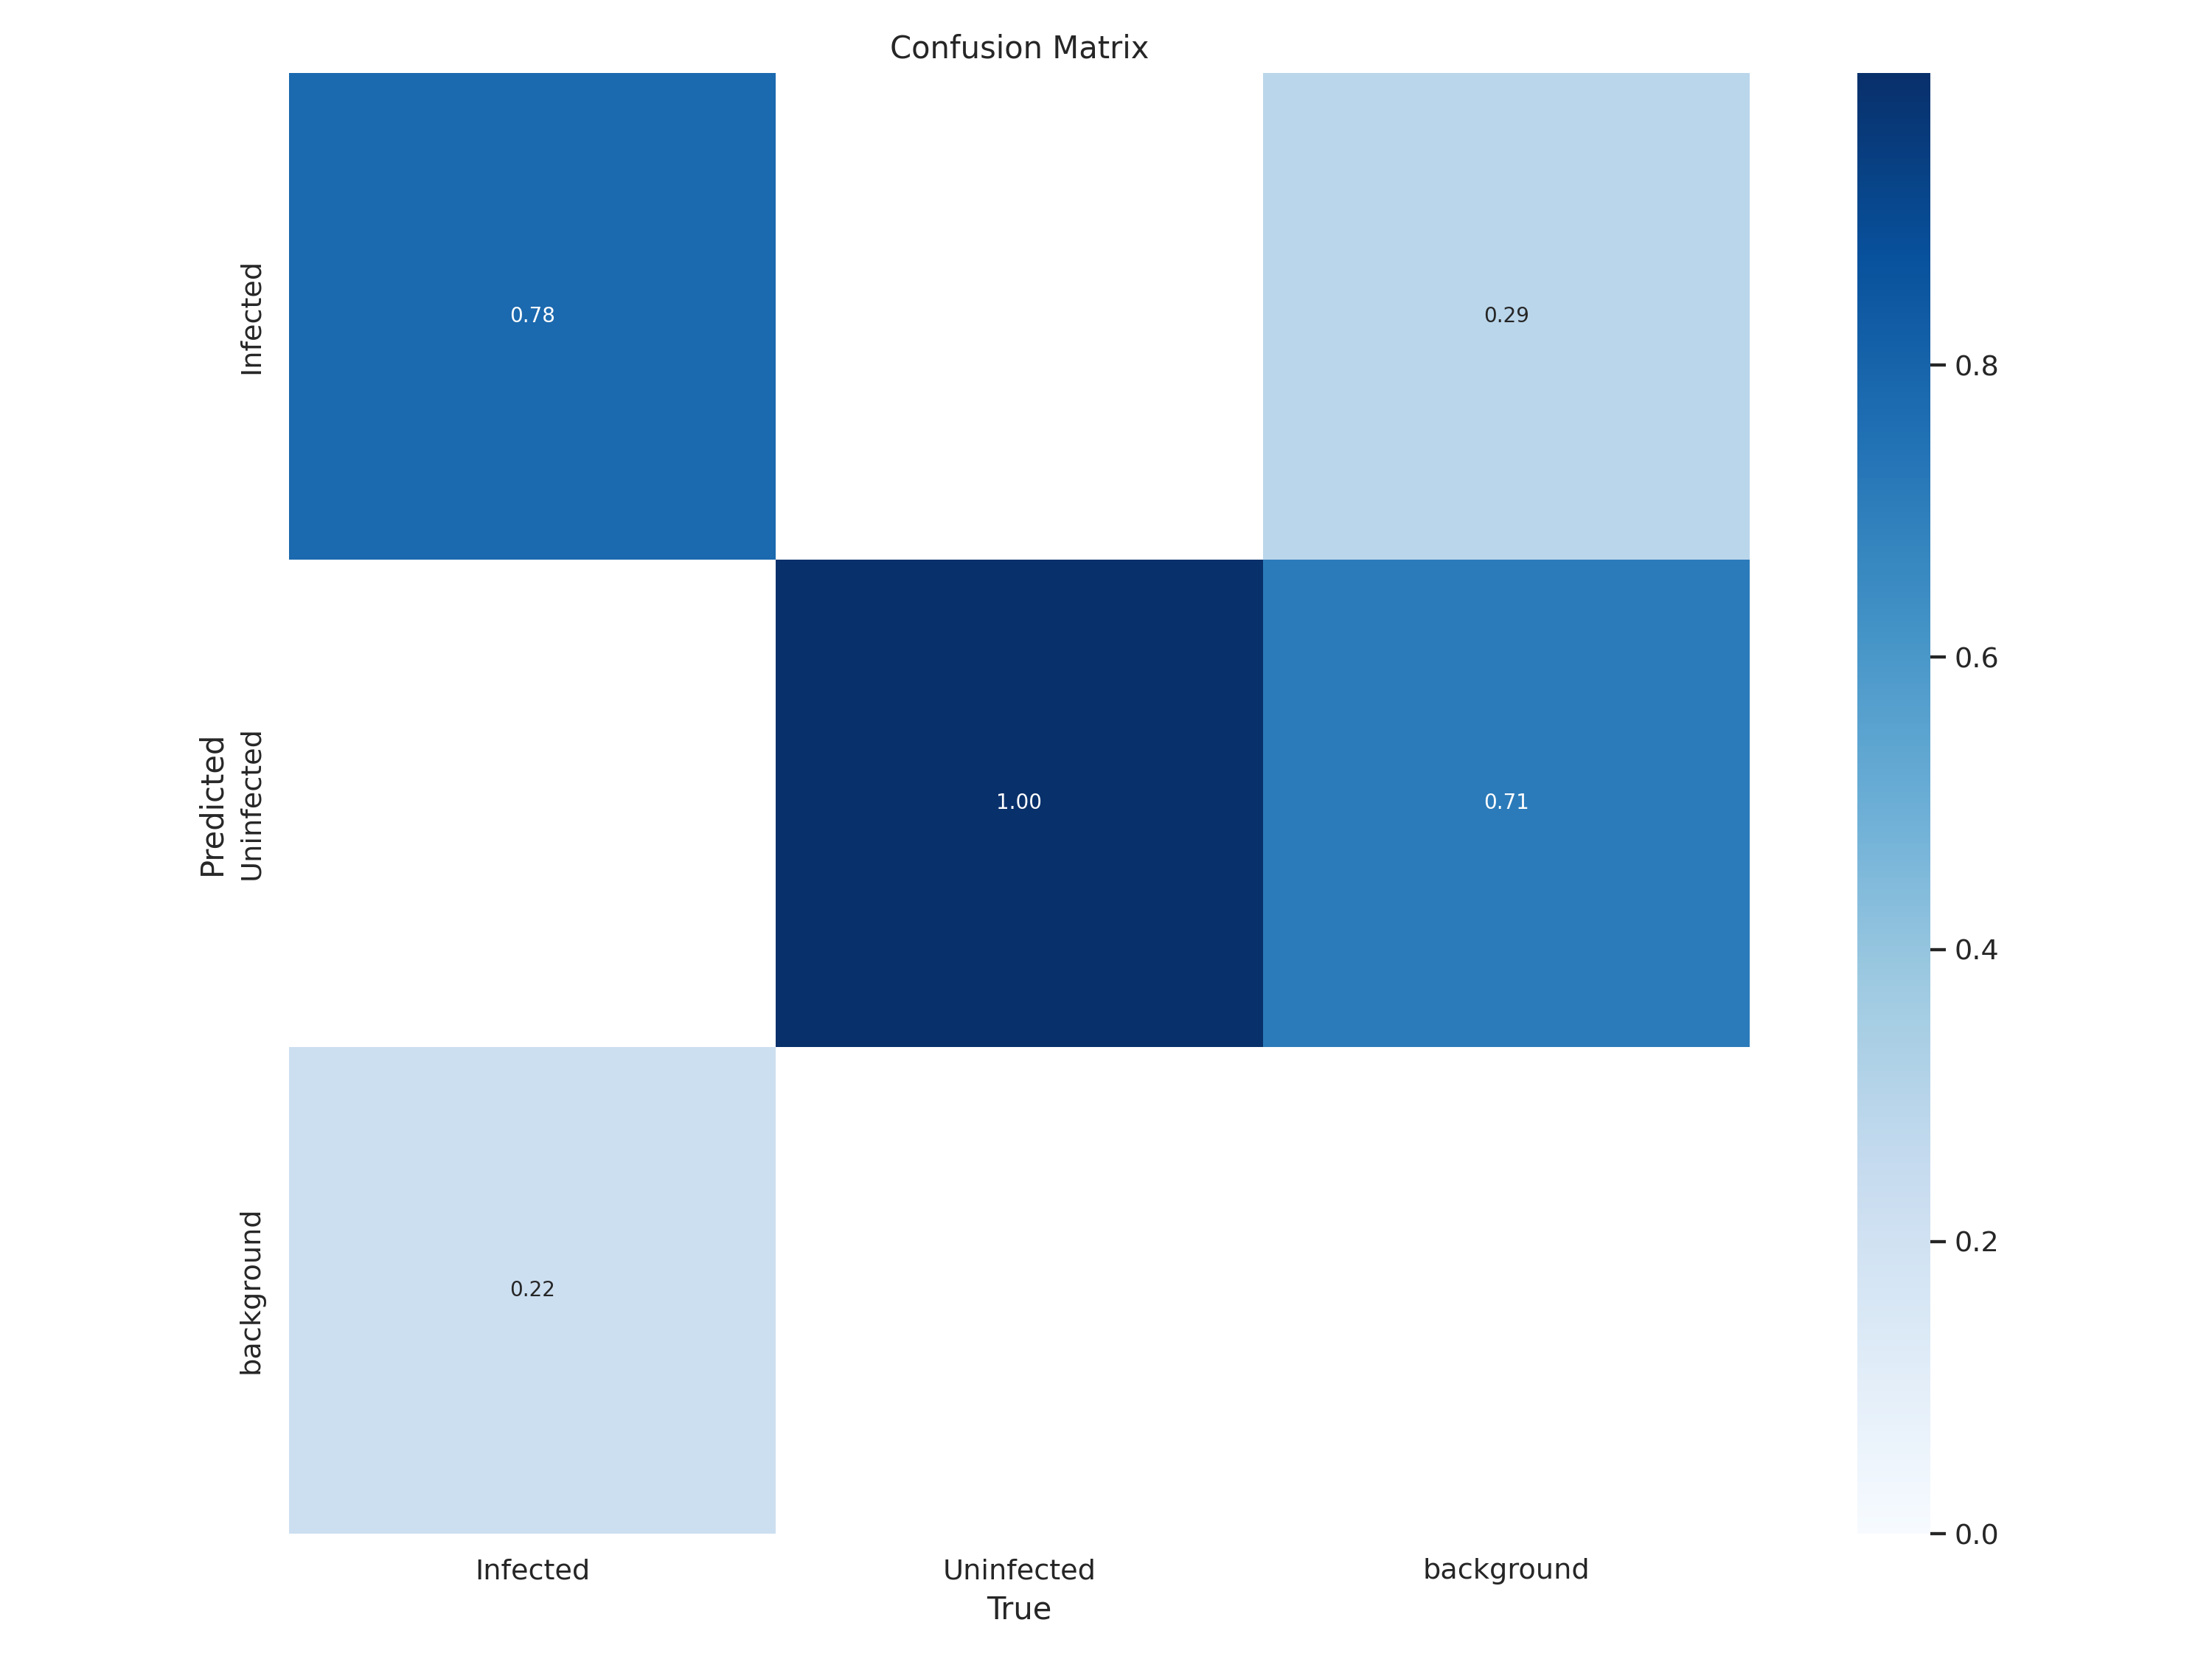

In [ ]:
%cd {HOME}
Image(filename=f'/content/datasets/runs/detect/train/confusion_matrix.png', width=600)

/content


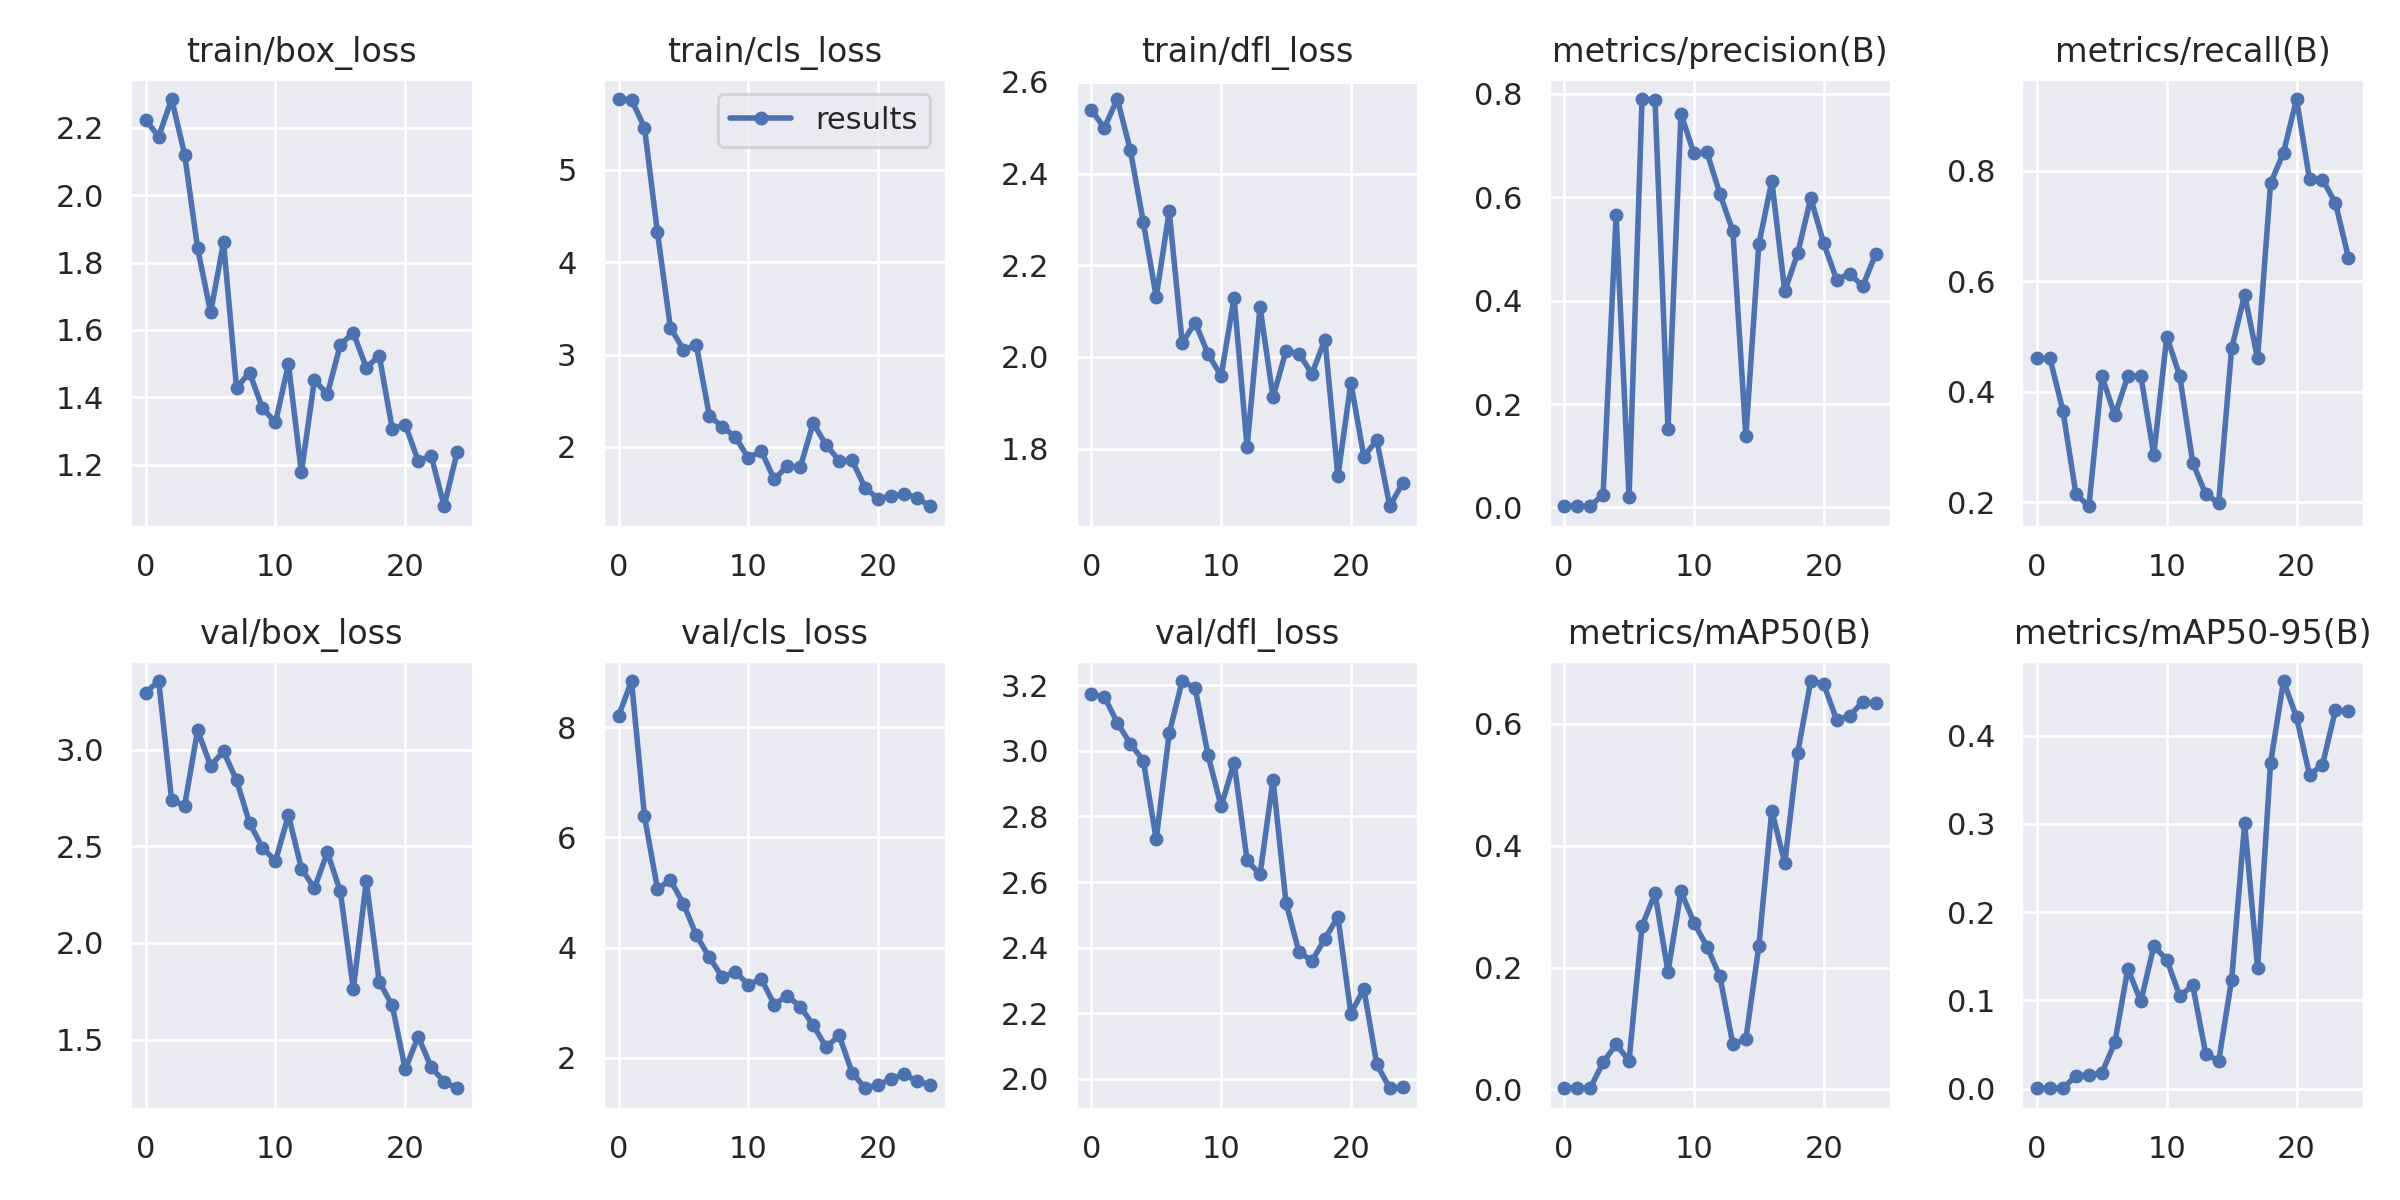

In [ ]:
%cd {HOME}
Image(filename=f'/content/datasets/runs/detect/train/results.png', width=600)

/content


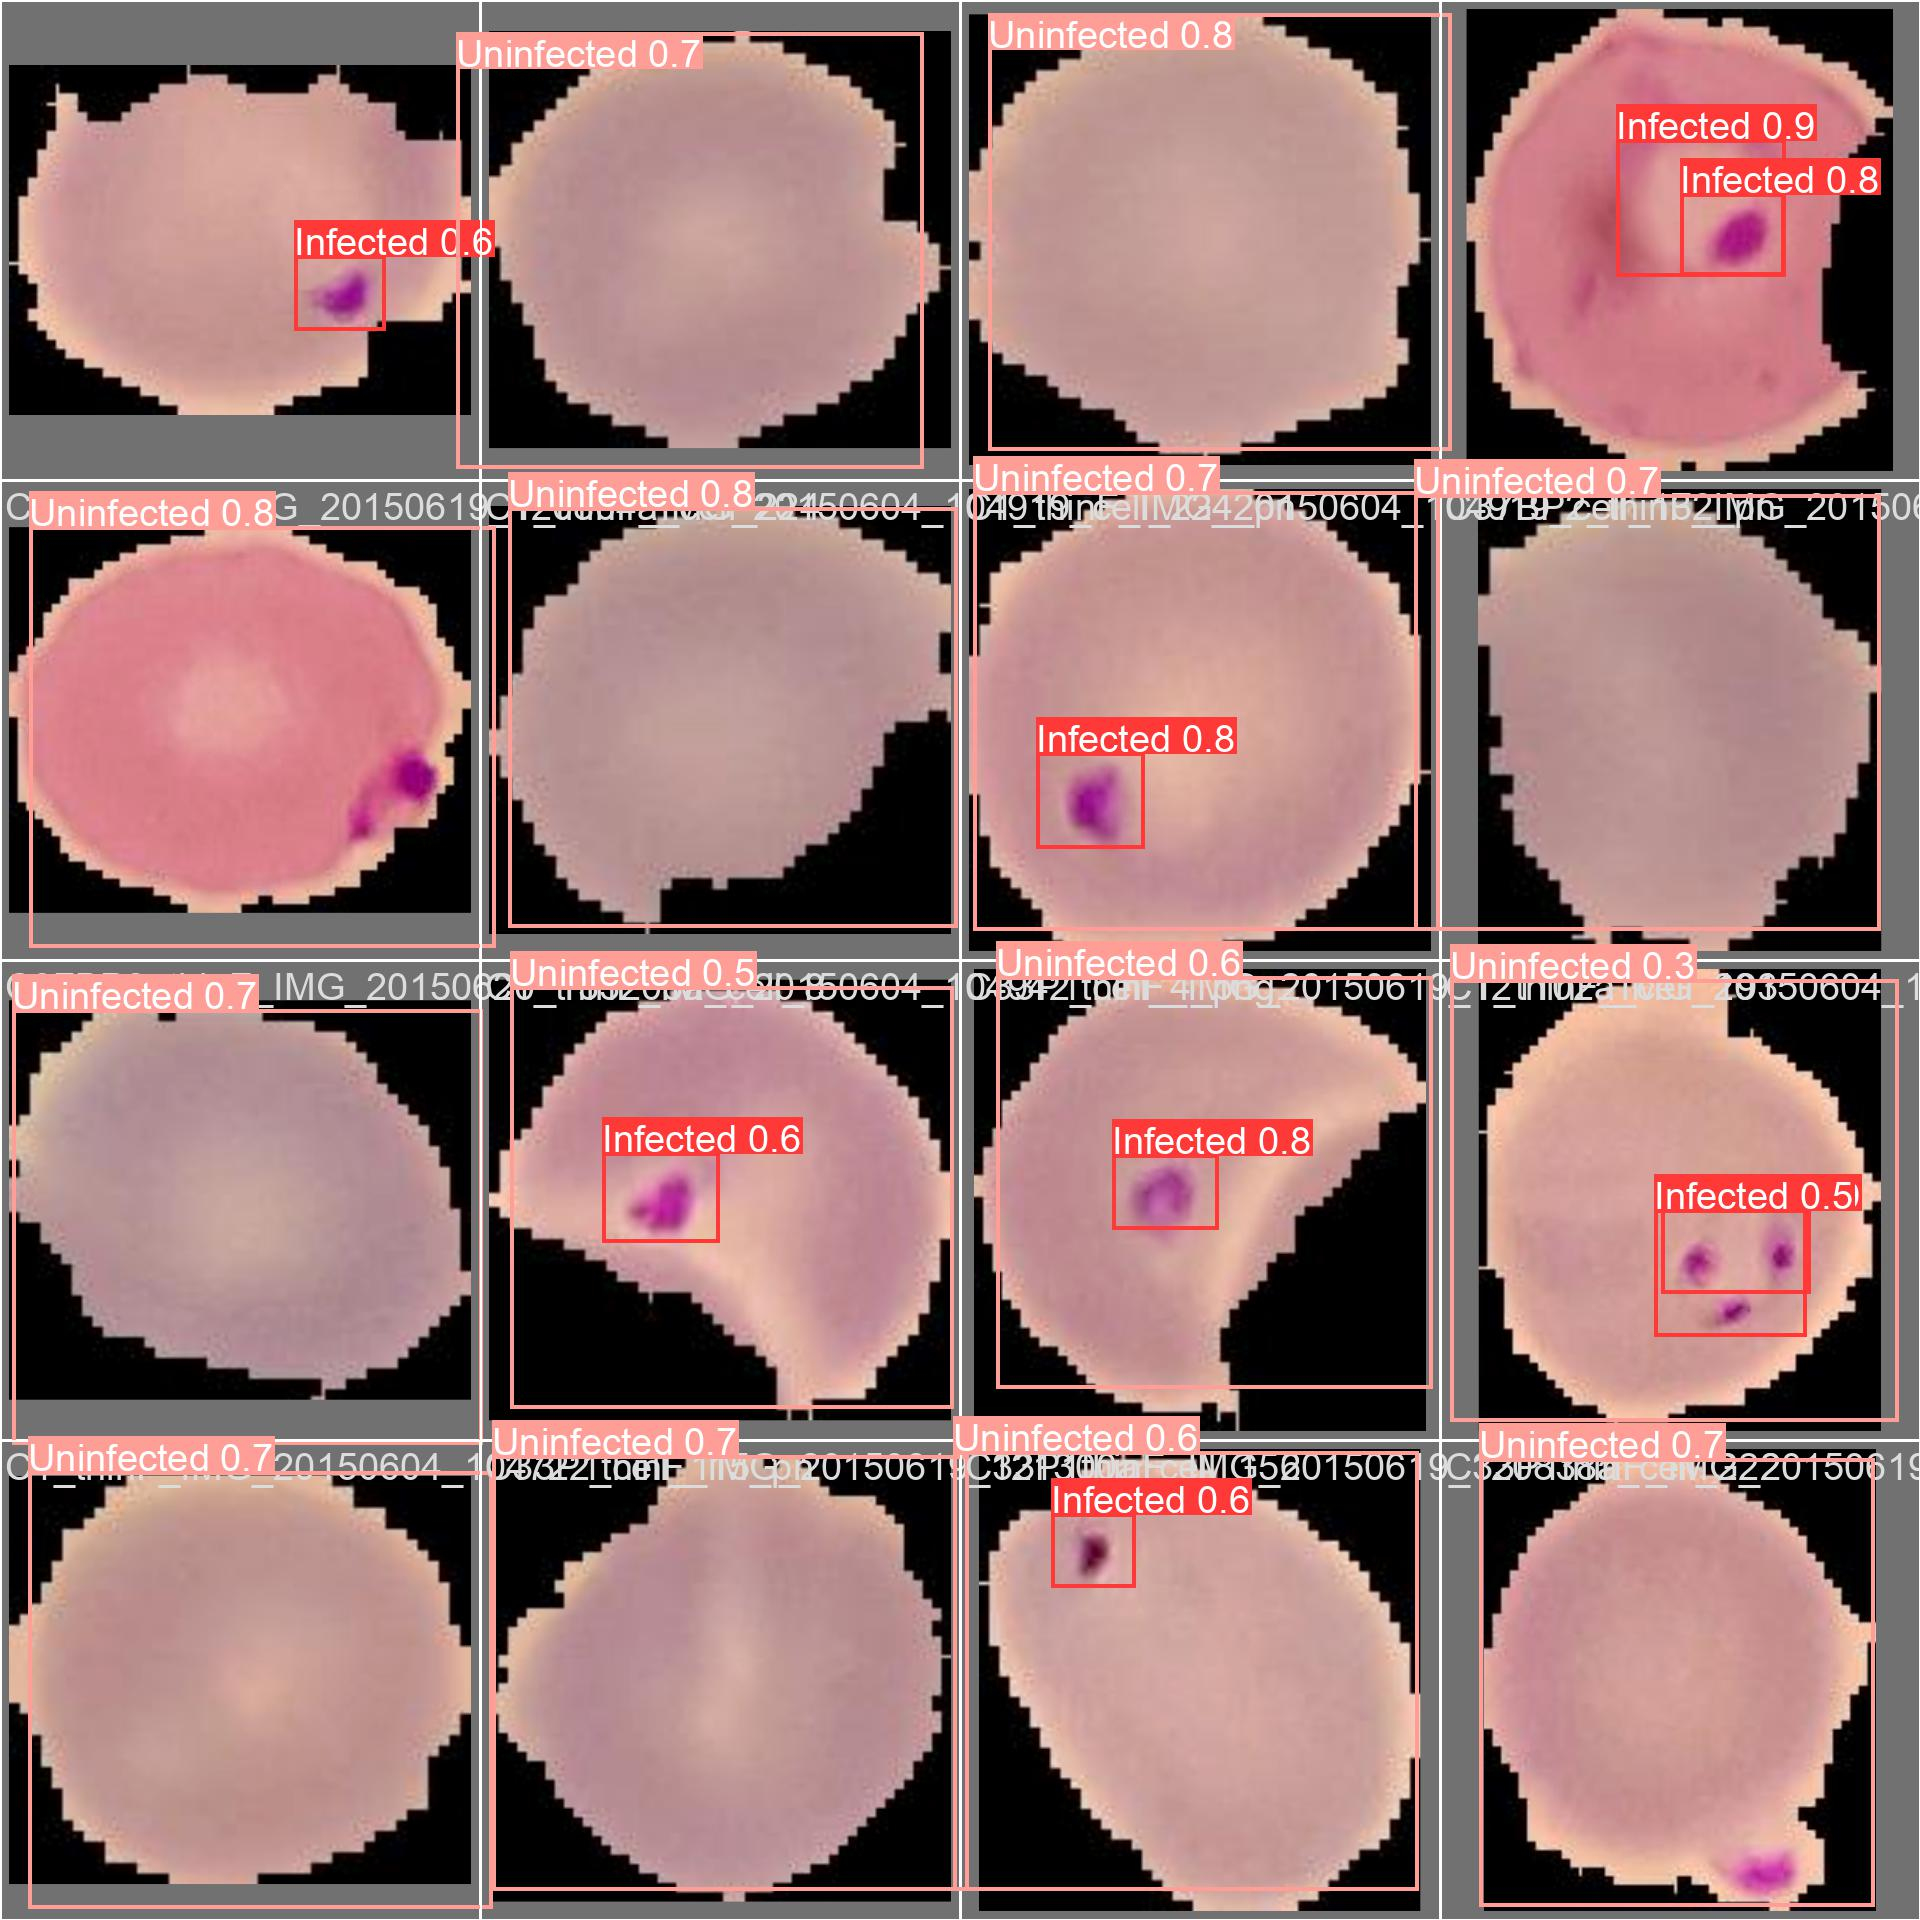

In [ ]:
%cd {HOME}
Image(filename=f'/content/datasets/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate

In [ ]:
!yolo task=detect mode=val model=/content/datasets/runs/detect/train/weights/best.pt data=/content/datasets/Malaria-Classification-2/data.yaml

2023-07-29 22:34:30.938051: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 22:34:32.072472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/Malaria-Classification-2/valid/labels.cache... 16 images, 0 backgrounds, 0 corrupt: 100% 16/16 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 7, len(boxes) = 16. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment

## Inference

In [ ]:
!yolo task=detect mode=predict model=/content/datasets/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

2023-07-29 22:34:44.492187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 22:34:45.819151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs
image 1/10 /content/Malaria-Classification-2/test/images/C1_thinF_IMG_20150604_104722_cell_191_png.rf.7d99b5895b49f96cbc704ce334a43679.jpg: 768x800 1 Uninfected, 71.2ms
image 2/10 /content/Malaria-Classification-2/test/images/C1_thinF_IMG_20150604_104919_cell_134_png.rf.0713be363ce513b3b75b261c68342667.jpg: 640x800 1 Uninfected, 62.0ms
image 3/10 /content/Malaria-Classification-2/test/images/C1

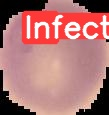

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:1]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [ ]:

#load model
model = project.version(dataset.version).model

#choose random test set image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image, confidence=40, overlap=30).json()
pred

running inference on C33P1thinF_IMG_20150619_115740a_cell_161_png.rf.ada6c34a97ce39d2020a057b40035874.jpg


{'predictions': [{'x': 67.5,
   'y': 53.0,
   'width': 53.0,
   'height': 60.0,
   'confidence': 0.4971068203449249,
   'class': 'Infected',
   'image_path': '/content/Malaria-Classification-2/test/images/C33P1thinF_IMG_20150619_115740a_cell_161_png.rf.ada6c34a97ce39d2020a057b40035874.jpg',
   'prediction_type': 'ObjectDetectionModel'}],
 'image': {'width': '124', 'height': '127'}}